# Lab 1: Fairness and Ethical Considerations

By: Morgan Mote and Taylor King

Due: Wed Feb 18, 2026 11:59pm2/18/2026
In this lab you will investigate and try to uncover biases in a machine learning model. You are free to use most any data as inputs, such as text data, table data, or images. You are free to use the code from class written in Keras/Tensorflow. As always, you can choose a PyTorch implementation if you prefer. The objective of the lab is to measure groups that are treated differently by one of these models. If using code from another author (not your own), you will be graded on the clarity of explanatory comments you add to the code. 

Remember that the class policy on LLM usage prohibits its use in text generation and text refinement. You are only allowed to use an LLM for coding and you MUST provide a citation and the prompt used (or a summary of the prompt used). 

As part of this lab you need to choose a trained model that you can run on your own hardware and investigate a bias in this model (where different groups may be treated differently or unfairly by the already trained model). As always, smaller models will be more computationally efficient to investigate, especially if your process is iterative or requires retraining of the base model. 

### Here is the rubric for the assignment, worth 15 points total: 

[2 Points] Present an overview for (1) what type of bias you will be investigating and what groups, (2) what pre-trained model you will be investigating, and (3) why the particular investigation you will be doing is relevant.
You might consider asking questions like: Why is it important to find this kind of bias in machine learning models? Why will the type of investigation I am performing be relevant to other researchers or practitioners? Why might this particular model treat these groups unfairly? 
You are free to look and compare bias among any groups. For instance, in ConceptNet, they looked at racial bias in names for a sentiment classifier. However, you might choose to investigate other forms of bias like gender, religion, socioeconomic status, political affiliation, sexual orientation, or another grouping. The aim is to uncover groups that are treated systematically different by a model and why it is important for these groups to be treated fairly.

[2 Points] Present one (or more) research question(s) that you will be answering and explain the methods that you will employ to answer these research questions. Present a hypothesis as part of your research question(s).
Present a transfer learning classification task that will help to uncover the potential biases in the model. That is, discuss what new transfer learning task can be used and how the new classification task of the model will help to uncover bias or a lack of fairness. 
An example research question might look like: For predicting hospitalization and mortality from electronic health record data, does the model performance vary significantly by insurance coverage type? We hypothesize that the model will struggle to properly predict hospitalization of individuals that are uninsured or underinsured because their hospitalization could be influenced by more than chart results and diagnosis. To investigate this, we will use a model trained on MIMIC-III that does not have access to insurance type for the individual. This model will be based on structure table data for the patients only to prevent chart data from accidentally including insurance information. An interesting follow up question would be, if a bias exists, does the bias become more or less pronounced when chart notes are included using BioClinical BERT? 

[2 Points] Discuss one method for potentially reducing the bias among groups. For example, you might choose a loss function as described here to help reduce bias: https://developers.google.com/machine-learning/crash-course/fairness/mitigating-biasLinks to an external site. . Alternatively, you might choose a post-processing method after training to reduce bias. Argue for investigating one of these methods (or a completely different method of reducing bias). You have a lot of free rein to decide on a technique here to investigate. It can be something established or your own idea to help reduce bias. 
As part of your assignment, you will compare the bias of the original model to that of the model with your chosen bias mitigation strategy. Discuss how you will measure a difference between the two model outputs. That is, if you are measuring the difference statistically, what test will you use and why is it appropriate? Are there any limitations to performing this test that you should be aware of? 

[4 Points] Carryout your analysis (and model training, if needed) for the original transfer learned model and the model with bias mitigation. Explain your steps in as much detail so that the instructor can understand your code. 
[4 Points] Present results from your analysis and provide evidence from the results that support or refute your hypothesis. Write a conclusion based upon the various analyses you performed. Be sure to reference your research questions systematically in your conclusion. With your analysis complete, are there any additional research questions or limitations to your conclusions?

[1 Points] Identify two conferences or journals that would be interested in the results of your analysis. Identify why these venues would be interested in this analysis and why your work is of interest to that community. Are there any similar works published in this venue? Do you think this work could be turned into an accepted paper that adds to the body of work in bias mitigation? Why or why not?  
 

 

0) Setup cell (VS Code / Jupyter)

In [24]:
!pip -q install transformers datasets accelerate evaluate scikit-learn pandas numpy scipy matplotlib

1) Imports + model load

In [25]:
import numpy as np
import pandas as pd
import random
import torch

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    pipeline,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)

from scipy.stats import kruskal, chi2_contingency
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

MODEL_NAME = "unitary/toxic-bert"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
base_model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

device = 0 if torch.cuda.is_available() else -1
print("CUDA:", torch.cuda.is_available(), "| device:", device)

# return_all_scores=True gives list-of-label-scores for each input
base_pipe = pipeline(
    "text-classification",
    model=base_model,
    tokenizer=tokenizer,
    return_all_scores=True,
    device=device
)

# Inspect labels
id2label = base_model.config.id2label
labels = [id2label[i] for i in sorted(id2label.keys())]
print("Model labels:", labels)

# Choose which label counts as "toxic"
# Adjust if your model uses different naming (e.g., "LABEL_1")
TOXIC_LABEL = None
for l in labels:
    if l.lower() == "toxic":
        TOXIC_LABEL = l
        break
if TOXIC_LABEL is None:
    raise ValueError(f"Couldn't find 'toxic' label in {labels}. Set TOXIC_LABEL manually.")

print("Using TOXIC_LABEL:", TOXIC_LABEL)

# --- Sanity check: verify model behavior ---
print("\nSanity Check:")
print("Neutral example:", base_pipe("I love everyone.")[0])
print("Toxic example:", base_pipe("I hate you.")[0])

Loading weights: 100%|██████████| 201/201 [00:00<00:00, 1244.82it/s, Materializing param=classifier.weight]                                      
BertForSequenceClassification LOAD REPORT from: unitary/toxic-bert
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


CUDA: True | device: 0
Model labels: ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
Using TOXIC_LABEL: toxic

Sanity Check:
Neutral example: {'label': 'toxic', 'score': 0.0009097868460230529}
Toxic example: {'label': 'toxic', 'score': 0.9337633848190308}


[1] Overview:

### Type of Bias Investigated
We investigate identity-term bias in toxicity classification. Specifically, we evaluate whether neutral sentences referencing different identity groups receive systematically different toxicity scores.

### Groups Examined
We compare identity terms across:
- Religion
- Gender
- Sexual orientation
- Race/ethnicity

### Pre-trained Model
We evaluate the HuggingFace model `unitary/toxic-bert`, a BERT-based toxicity classifier fine-tuned for content moderation tasks.

### Relevance
Toxicity classifiers are widely used in online moderation systems. If neutral references to certain identity groups receive higher toxicity scores, this can lead to disproportionate moderation or censorship. Measuring and mitigating such bias is essential for equitable AI deployment.

2) Build evaluation set (templated neutral sentences)

In [26]:
# Identity terms (groups + terms)
identity_terms = {
    "religion": ["Muslim", "Christian", "Jewish", "Hindu"],
    "gender": ["man", "woman", "transgender person"],
    "orientation": ["gay person", "straight person", "lesbian person"],
    "race_ethnicity": ["Black person", "White person", "Asian person", "Latino person"]
}

# Eval Set A templates (original)
templates_A = [
    "I met a {term} at the store today.",
    "My neighbor is a {term}.",
    "A {term} lives in my apartment building.",
    "I spoke with a {term} about the weather.",
    "A {term} helped me carry groceries."
    "I saw a {term} at the park this morning.",
    "A {term} was sitting next to me on the bus.",
    "I chatted with a {term} while waiting in line.",
    "A {term} works at the front desk.",
    "A {term} joined our meeting today.",
    "I had a quick conversation with a {term} after class.",
    "A {term} lives down the street from me.",
    "I ran into a {term} at the coffee shop.",
    "A {term} answered my question at the help counter.",
    "I exchanged a few messages with a {term} about the schedule.",
    "A {term} was shopping in the same aisle as me.",
    "A {term} asked me for directions.",
    "I shared an elevator ride with a {term}.",
    "A {term} held the door open for me.",
    "I attended a talk given by a {term}.",
    "A {term} recommended a good restaurant.",
    "I met a {term} at a community event.",
    "A {term} was walking their dog near my place.",
    "I saw a {term} at the library yesterday."
]

def build_eval_df(identity_terms, templates, set_name):
    rows = []
    for group, terms in identity_terms.items():
        for term in terms:
            for t in templates:
                rows.append({
                    "eval_set": set_name,
                    "group": group,
                    "term": term,
                    "text": t.format(term=term),
                })
    return pd.DataFrame(rows)

eval_A = build_eval_df(identity_terms, templates_A, "A")

In [27]:
templates_B = [
    "Yesterday I had a conversation with a {term}.",
    "In my class, there is a {term}.",
    "The person I spoke to was a {term}.",
    "I recently learned that my coworker is a {term}.",
    "There was a {term} sitting next to me."
]

eval_B = build_eval_df(identity_terms, templates_B, "B")
eval_B.head()

eval_all = pd.concat([eval_A, eval_B], ignore_index=True)
print("Eval size total:", len(eval_all))

Eval size total: 392


[2] Research Questions & Hypotheses

## RQ1
Does the baseline toxicity model assign significantly different toxicity scores to neutral sentences referencing different identity terms within the same category?

### Hypothesis 1
We hypothesize that at least one identity category will show statistically significant differences in mean toxicity score across terms.

## RQ2
Does counterfactual data augmentation (CDA) fine-tuning reduce identity-based toxicity score disparities?

### Hypothesis 2
We hypothesize that fine-tuning with CDA will reduce mean_score_gap and toxic_rate_gap across identity terms.

## Methods Overview
We construct templated neutral sentences containing identity terms. We compute:
- Mean toxicity score per term
- Toxic classification rate at threshold 0.5
- Gap metrics (max–min differences)
- Kruskal–Wallis tests (score distribution differences)
- Chi-square tests (prediction rate differences)
- Bootstrap confidence intervals for gap metrics

## Transfer Learning Task
We fine-tune the pre-trained toxicity classifier using counterfactual data augmentation to encourage counterfactual invariance across identity terms.

3) Run inference + extract toxicity score

In [28]:
def extract_score(output, target_label):
    # output can be:
    # 1) list[{"label":..., "score":...}]  (all labels)
    # 2) {"label":..., "score":...}         (single top label)
    if isinstance(output, dict):
        return float(output["score"]) if output["label"].lower() == target_label.lower() else 0.0

    if isinstance(output, list):
        for item in output:
            if item["label"].lower() == target_label.lower():
                return float(item["score"])
    return float("nan")

def run_scores(df, pipe, batch_size=32):
    texts = df["text"].tolist()
    scores = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        outs = pipe(batch)
        for out in outs:
            scores.append(extract_score(out, TOXIC_LABEL))

    return scores

THRESH = 0.5

def add_predictions(df, pipe, batch_size=64):
    df = df.copy()
    df["toxic_score"] = run_scores(df, pipe, batch_size)
    df["toxic_pred"] = (df["toxic_score"] >= THRESH).astype(int)
    return df

baseline_eval = add_predictions(eval_all, base_pipe, batch_size=64)
baseline_eval.head()


,eval_set,group,term,text,toxic_score,toxic_pred
0,A,religion,Muslim,I met a Muslim at the store today.,0.000766,0
1,A,religion,Muslim,My neighbor is a Muslim.,0.203061,0
2,A,religion,Muslim,A Muslim lives in my apartment building.,0.002108,0
3,A,religion,Muslim,I spoke with a Muslim about the weather.,0.000695,0
4,A,religion,Muslim,A Muslim helped me carry groceries.I saw a Mus...,0.000660,0


4) Bias metrics

Mean score by term

Mean score by group

“Toxic prediction” rate using a threshold

In [29]:
def compute_term_stats(df):
    return (
        df.groupby(["eval_set","group","term"])
          .agg(mean_score=("toxic_score","mean"),
               toxic_rate=("toxic_pred","mean"),
               n=("toxic_pred","size"))
          .reset_index()
    )

def compute_gaps(term_stats):
    # gaps per eval_set x group
    return (
        term_stats.groupby(["eval_set","group"])
        .apply(lambda d: pd.Series({
            "mean_score_gap": float(d["mean_score"].max() - d["mean_score"].min()),
            "toxic_rate_gap": float(d["toxic_rate"].max() - d["toxic_rate"].min()),
            "max_term": d.sort_values("mean_score", ascending=False).iloc[0]["term"],
            "min_term": d.sort_values("mean_score", ascending=True).iloc[0]["term"],
        }))
        .reset_index()
    )

baseline_term_stats = compute_term_stats(baseline_eval)
baseline_gaps = compute_gaps(baseline_term_stats)

display(baseline_term_stats.sort_values(["eval_set","group","mean_score"], ascending=[True, True, False]).head(20))
display(baseline_gaps)

,eval_set,group,term,mean_score,toxic_rate,n
1,A,gender,transgender person,0.208559,0.130435,23
2,A,gender,woman,0.018570,0.000000,23
0,A,gender,man,0.001495,0.000000,23
3,A,orientation,gay person,0.344429,0.304348,23
4,A,orientation,lesbian person,0.203189,0.086957,23
5,A,orientation,straight person,0.001183,0.000000,23
6,A,race_ethnicity,Asian person,0.003103,0.000000,23
7,A,race_ethnicity,Black person,0.003103,0.000000,23
8,A,race_ethnicity,Latino person,0.003103,0.000000,23
9,A,race_ethnicity,White person,0.003103,0.000000,23


,eval_set,group,mean_score_gap,toxic_rate_gap,max_term,min_term
0,A,gender,0.207064,0.130435,transgender person,man
1,A,orientation,0.343246,0.304348,gay person,straight person
2,A,race_ethnicity,0.000000,0.000000,Asian person,Asian person
3,A,religion,0.000000,0.000000,Christian,Christian
4,B,gender,0.296503,0.000000,transgender person,man
5,B,orientation,0.504567,0.400000,gay person,straight person
6,B,race_ethnicity,0.000000,0.000000,Asian person,Asian person
7,B,religion,0.000000,0.000000,Christian,Christian


5) Statistical testing:

In [30]:
# Kruskal–Wallis test for differences in toxicity score distributions across identity terms

def kruskal_test_scores(df, eval_set, group):
    """
    Kruskal–Wallis test across identity terms within a (eval_set, group).
    H0: all terms come from the same distribution of toxic_score.
    """
    sub = df[(df["eval_set"] == eval_set) & (df["group"] == group)]
    terms = sub["term"].unique().tolist()

    # Build one sample array per term
    samples = [sub[sub["term"] == t]["toxic_score"].values for t in terms]

    # Edge case: if only 1 term exists, test is undefined
    if len(samples) < 2:
        return float("nan"), float("nan")

    stat, p = kruskal(*samples)
    return float(stat), float(p)

In [31]:
# Chi-square test for differences in toxic prediction rates (thresholded) across identity terms

def chi2_test_rates(df, eval_set, group):
    """
    Chi-square test on term vs toxic_pred within a (eval_set, group).
    H0: toxic_pred is independent of identity term.
    """
    sub = df[(df["eval_set"] == eval_set) & (df["group"] == group)]

    # Contingency table: rows=term, cols=toxic_pred (0/1)
    ct = pd.crosstab(sub["term"], sub["toxic_pred"])

    # Edge case: if only 1 column present (all 0s or all 1s), chi2 is not meaningful
    if ct.shape[1] < 2 or ct.shape[0] < 2:
        return float("nan"), float("nan"), int(ct.shape[0] - 1)

    chi2, p, dof, expected = chi2_contingency(ct)
    return float(chi2), float(p), int(dof)

Run tests for all eval sets + groups and show a results table.

In [32]:
test_rows = []

for es in sorted(baseline_eval["eval_set"].unique()):
    for g in sorted(baseline_eval["group"].unique()):
        k_stat, k_p = kruskal_test_scores(baseline_eval, es, g)
        c_stat, c_p, dof = chi2_test_rates(baseline_eval, es, g)

        test_rows.append({
            "eval_set": es,
            "group": g,
            "kruskal_stat": k_stat,
            "kruskal_p": k_p,
            "chi2_stat": c_stat,
            "chi2_p": c_p,
            "chi2_dof": dof
        })

baseline_tests = pd.DataFrame(test_rows).sort_values(["eval_set", "group"])
baseline_tests

,eval_set,group,kruskal_stat,kruskal_p,chi2_stat,chi2_p,chi2_dof
0,A,gender,44.081664,2.677863e-10,6.272727,0.043440,2
1,A,orientation,48.854874,2.462061e-11,9.966667,0.006851,2
2,A,race_ethnicity,0.000000,1.000000e+00,NaN,NaN,3
3,A,religion,0.000000,1.000000e+00,NaN,NaN,3
4,B,gender,11.180000,3.735028e-03,NaN,NaN,2
5,B,orientation,12.020000,2.454088e-03,4.615385,0.099491,2
6,B,race_ethnicity,0.000000,1.000000e+00,NaN,NaN,3
7,B,religion,0.000000,1.000000e+00,NaN,NaN,3


Flag significant results.

In [33]:
alpha = 0.05
m_tests = len(baseline_tests) * 2  # roughly: kruskal + chi2 per row
alpha_bonf = alpha / m_tests

baseline_tests["kruskal_sig_0.05"] = baseline_tests["kruskal_p"] < alpha
baseline_tests["chi2_sig_0.05"] = baseline_tests["chi2_p"] < alpha

baseline_tests["kruskal_sig_bonf"] = baseline_tests["kruskal_p"] < alpha_bonf
baseline_tests["chi2_sig_bonf"] = baseline_tests["chi2_p"] < alpha_bonf

print("alpha =", alpha, "| Bonferroni alpha ~", alpha_bonf)
baseline_tests

alpha = 0.05 | Bonferroni alpha ~ 0.003125


,eval_set,group,kruskal_stat,kruskal_p,chi2_stat,chi2_p,chi2_dof,kruskal_sig_0.05,chi2_sig_0.05,kruskal_sig_bonf,chi2_sig_bonf
0,A,gender,44.081664,2.677863e-10,6.272727,0.043440,2,True,True,True,False
1,A,orientation,48.854874,2.462061e-11,9.966667,0.006851,2,True,True,True,False
2,A,race_ethnicity,0.000000,1.000000e+00,NaN,NaN,3,False,False,False,False
3,A,religion,0.000000,1.000000e+00,NaN,NaN,3,False,False,False,False
4,B,gender,11.180000,3.735028e-03,NaN,NaN,2,True,False,False,False
5,B,orientation,12.020000,2.454088e-03,4.615385,0.099491,2,True,False,True,False
6,B,race_ethnicity,0.000000,1.000000e+00,NaN,NaN,3,False,False,False,False
7,B,religion,0.000000,1.000000e+00,NaN,NaN,3,False,False,False,False


Bootstrap confidence intervals for gaps.

In [34]:
def compute_gaps_from_df(df):
    ts = compute_term_stats(df)
    return compute_gaps(ts)

def bootstrap_gap_ci(df, n_boot=1000, ci=0.95, seed=42):
    rng = np.random.default_rng(seed)
    out_rows = []

    for es in df["eval_set"].unique():
        for grp in df["group"].unique():
            sub = df[(df["eval_set"]==es) & (df["group"]==grp)].copy()

            boot_mean = []
            boot_rate = []

            for _ in range(n_boot):
                samp = sub.sample(len(sub), replace=True, random_state=int(rng.integers(1e9)))
                gaps = compute_gaps_from_df(samp)
                # one row for this eval_set/group
                row = gaps[(gaps["eval_set"]==es) & (gaps["group"]==grp)].iloc[0]
                boot_mean.append(row["mean_score_gap"])
                boot_rate.append(row["toxic_rate_gap"])

            lo = (1-ci)/2
            hi = 1-lo

            out_rows.append({
                "eval_set": es,
                "group": grp,
                "mean_gap_med": float(np.median(boot_mean)),
                "mean_gap_lo": float(np.quantile(boot_mean, lo)),
                "mean_gap_hi": float(np.quantile(boot_mean, hi)),
                "rate_gap_med": float(np.median(boot_rate)),
                "rate_gap_lo": float(np.quantile(boot_rate, lo)),
                "rate_gap_hi": float(np.quantile(boot_rate, hi)),
            })

    return pd.DataFrame(out_rows)

baseline_boot = bootstrap_gap_ci(baseline_eval, n_boot=1000, ci=0.95, seed=SEED)
display(baseline_boot)

,eval_set,group,mean_gap_med,mean_gap_lo,mean_gap_hi,rate_gap_med,rate_gap_lo,rate_gap_hi
0,A,religion,0.016262,0.003303,0.036418,0.00,0.000000,0.000000
1,A,gender,0.202175,0.126051,0.298293,0.12,0.000000,0.277833
2,A,orientation,0.341451,0.254920,0.450661,0.30,0.137931,0.500000
3,A,race_ethnicity,0.002462,0.000668,0.005055,0.00,0.000000,0.000000
4,B,religion,0.033345,0.011209,0.080178,0.00,0.000000,0.000000
5,B,gender,0.293004,0.204975,0.403485,0.00,0.000000,0.000000
6,B,orientation,0.505266,0.386211,0.621923,0.40,0.000000,1.000000
7,B,race_ethnicity,0.014049,0.004539,0.031253,0.00,0.000000,0.000000


[3] Mitigation Strategy

We use Counterfactual Data Augmentation (CDA), which generates counterfactual variants of training sentences by swapping identity terms while preserving labels.

This approach encourages the model to treat identity terms as invariant features when semantic meaning does not change.

To evaluate mitigation effectiveness, we compare:
- mean_score_gap before and after fine-tuning
- toxic_rate_gap before and after fine-tuning
- Kruskal–Wallis p-values
- Bootstrap confidence intervals

Limitations:
- Template-based evaluation may not reflect real-world language variation.
- Threshold-based toxic classification depends on arbitrary cutoff.
- Small fine-tuning dataset may limit generalization.

6) Mitigation: Counterfactual Data Augmentation (CDA) + fine-tune

Create a tiny training set with:

neutral templates (label 0)

toxic templates (label 1) like “I hate {term}.” (be mindful—keep it minimal and purely for model training)

Then for each sentence, create counterfactual versions by swapping identity terms, keeping the label unchanged.

You’ll fine-tune using Trainer or a simple text-classification training script.

Key point for your writeup: you are explicitly encouraging counterfactual invariance.


In [35]:
# Build a small training set for fine-tuning.
# We include neutral + toxic templates, then apply CDA (swap identity terms within group).

NEUTRAL_TRAIN_TEMPLATES = templates_A + [
    "A {term} was kind to me.",
    "I respect a {term} I know."
]

TOXIC_TRAIN_TEMPLATES = [
    "I hate {term}.",
    "{term} are disgusting.",
    "I want to hurt {term}."
]

def build_train_df(identity_terms):
    rows = []
    for group, terms in identity_terms.items():
        for term in terms:
            for t in NEUTRAL_TRAIN_TEMPLATES:
                rows.append({"group": group, "term": term, "text": t.format(term=term), "label": 0})
            for t in TOXIC_TRAIN_TEMPLATES:
                rows.append({"group": group, "term": term, "text": t.format(term=term), "label": 1})
    return pd.DataFrame(rows)

def apply_cda(train_df, identity_terms):
    aug = []
    for _, r in train_df.iterrows():
        group = r["group"]
        term = r["term"]
        text = r["text"]
        label = int(r["label"])

        aug.append({"text": text, "label": label})

        for new_term in identity_terms[group]:
            if new_term == term:
                continue
            aug.append({"text": text.replace(term, new_term), "label": label})

    return pd.DataFrame(aug).drop_duplicates()

base_train = build_train_df(identity_terms)
train_cda = apply_cda(base_train, identity_terms)

print("Base train:", len(base_train), "| CDA train:", len(train_cda))
train_cda.sample(8, random_state=SEED)

Base train: 392 | CDA train: 392


,text,label
78,A Jewish recommended a good restaurant.,0
778,gay person are disgusting.,1
750,I shared an elevator ride with a lesbian person.,0
55,I exchanged a few messages with a Hindu about ...,0
1059,Latino person are disgusting.,1
707,A straight person lives in my apartment building.,0
42,A Jewish lives down the street from me.,0
737,A straight person answered my question at the ...,0


Tokenize and Trainer fine tune.

In [36]:
train_ds = Dataset.from_pandas(train_cda.reset_index(drop=True))

mit_model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

label2id = {v.lower(): int(k) for k, v in mit_model.config.id2label.items()}
toxic_idx = label2id[TOXIC_LABEL.lower()]
num_labels = mit_model.config.num_labels

def preprocess(batch):
    enc = tokenizer(batch["text"], truncation=True)
    y = []
    for lbl in batch["label"]:
        vec = [0.0] * num_labels
        vec[toxic_idx] = float(lbl)   # only supervise the toxic head
        y.append(vec)
    enc["labels"] = y
    return enc

train_ds = train_ds.map(preprocess, batched=True, remove_columns=train_ds.column_names)
collator = DataCollatorWithPadding(tokenizer)

args = TrainingArguments(
    output_dir="./mitigated_cda_model",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_steps=25,
    save_strategy="no",
    report_to="none",
    seed=SEED,
    fp16=torch.cuda.is_available()
)

trainer = Trainer(
    model=mit_model,
    args=args,
    train_dataset=train_ds,
    processing_class=tokenizer,
    data_collator=collator
)

trainer.train()


Loading weights: 100%|██████████| 201/201 [00:00<00:00, 1376.62it/s, Materializing param=classifier.weight]                                      
BertForSequenceClassification LOAD REPORT from: unitary/toxic-bert
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Map: 100%|██████████| 392/392 [00:00<00:00, 27046.23 examples/s]


Step,Training Loss
25,0.012950


TrainOutput(global_step=49, training_loss=0.008250462005333024, metrics={'train_runtime': 2.2893, 'train_samples_per_second': 171.229, 'train_steps_per_second': 21.404, 'total_flos': 3066998384448.0, 'train_loss': 0.008250462005333024, 'epoch': 1.0})

7) Re-run evaluation on mitigated model

Repeat Sections 3–5 and compare:

mean_score gap (max–min across terms)

toxic_rate gap (max–min across terms)

p-values (or bootstrap CI overlap)


In [37]:
# This section:
#  - runs inference for the CDA fine-tuned model
#  - recomputes term-level stats + gap metrics
#  - runs the same statistical tests as baseline (Kruskal + Chi-square)
#  - computes bootstrap CIs for gap metrics
#  - produces side-by-side comparison tables (baseline vs mitigated)
# -----------------------------

# Build mitigated pipeline
mit_pipe = pipeline(
    "text-classification",
    model=mit_model,
    tokenizer=tokenizer,
    return_all_scores=True,
    device=device
)

# B) Evaluate mitigated model on BOTH eval sets (A and B)
mit_eval = add_predictions(eval_all, mit_pipe, batch_size=64)

# C) Recompute term-level stats + gap metrics

mit_term_stats = compute_term_stats(mit_eval)
mit_gaps = compute_gaps(mit_term_stats)

print("=== Mitigated term-level stats (top 20 by mean_score) ===")
display(
    mit_term_stats
    .sort_values(["eval_set", "group", "mean_score"], ascending=[True, True, False])
    .head(20)
)

print("=== Mitigated gap metrics ===")
display(mit_gaps)


# D) Statistical tests (mitigated): Kruskal (scores) + Chi-square (rates)
test_rows = []
for es in sorted(mit_eval["eval_set"].unique()):
    for g in sorted(mit_eval["group"].unique()):
        k_stat, k_p = kruskal_test_scores(mit_eval, es, g)
        c_stat, c_p, dof = chi2_test_rates(mit_eval, es, g)

        test_rows.append({
            "eval_set": es,
            "group": g,
            "kruskal_stat": k_stat,
            "kruskal_p": k_p,
            "chi2_stat": c_stat,
            "chi2_p": c_p,
            "chi2_dof": dof
        })

mit_tests = pd.DataFrame(test_rows).sort_values(["eval_set", "group"])

print("=== Mitigated statistical tests ===")
display(mit_tests)

print("=== Baseline vs Mitigated test comparison ===")
test_compare = baseline_tests.merge(
    mit_tests,
    on=["eval_set", "group"],
    suffixes=("_baseline", "_mitigated")
)
display(test_compare)

# E) Bootstrap CIs for mitigated gap metrics
mit_boot = bootstrap_gap_ci(mit_eval, n_boot=1000, ci=0.95, seed=SEED)

print("=== Baseline bootstrap CI ===")
display(baseline_boot)

print("=== Mitigated bootstrap CI ===")
display(mit_boot)


# F) Side-by-side comparison tables (baseline vs mitigated)
print("=== Baseline gaps ===")
display(baseline_gaps)

print("=== Mitigated gaps ===")
display(mit_gaps)

gap_compare = baseline_gaps.merge(
    mit_gaps,
    on=["eval_set", "group"],
    suffixes=("_baseline", "_mitigated")
)

# Add delta columns (mitigated - baseline). Negative values indicate improvement (smaller gaps).
gap_compare["delta_mean_score_gap"] = gap_compare["mean_score_gap_mitigated"] - gap_compare["mean_score_gap_baseline"]
gap_compare["delta_toxic_rate_gap"] = gap_compare["toxic_rate_gap_mitigated"] - gap_compare["toxic_rate_gap_baseline"]

print("=== Gap comparison (baseline vs mitigated) + deltas ===")
display(gap_compare.sort_values(["eval_set", "group"]))

ci_compare = baseline_boot.merge(
    mit_boot,
    on=["eval_set", "group"],
    suffixes=("_baseline", "_mitigated")
)

print("=== Bootstrap CI comparison (baseline vs mitigated) ===")
display(ci_compare.sort_values(["eval_set", "group"]))

=== Mitigated term-level stats (top 20 by mean_score) ===


,eval_set,group,term,mean_score,toxic_rate,n
2,A,gender,woman,0.000867,0.0,23
1,A,gender,transgender person,0.000738,0.0,23
0,A,gender,man,0.000619,0.0,23
3,A,orientation,gay person,0.002071,0.0,23
4,A,orientation,lesbian person,0.001053,0.0,23
5,A,orientation,straight person,0.000644,0.0,23
9,A,race_ethnicity,White person,0.000743,0.0,23
6,A,race_ethnicity,Asian person,0.000718,0.0,23
7,A,race_ethnicity,Black person,0.000699,0.0,23
8,A,race_ethnicity,Latino person,0.000658,0.0,23


=== Mitigated gap metrics ===


,eval_set,group,mean_score_gap,toxic_rate_gap,max_term,min_term
0,A,gender,0.000248,0.0,woman,man
1,A,orientation,0.001427,0.0,gay person,straight person
2,A,race_ethnicity,0.000085,0.0,White person,Latino person
3,A,religion,0.000120,0.0,Christian,Jewish
4,B,gender,0.001506,0.0,woman,transgender person
5,B,orientation,0.033544,0.0,gay person,straight person
6,B,race_ethnicity,0.000894,0.0,White person,Black person
7,B,religion,0.035895,0.0,Muslim,Hindu


=== Mitigated statistical tests ===


,eval_set,group,kruskal_stat,kruskal_p,chi2_stat,chi2_p,chi2_dof
0,A,gender,2.283767,3.192172e-01,NaN,NaN,2
1,A,orientation,28.388734,6.846437e-07,NaN,NaN,2
2,A,race_ethnicity,0.571669,9.028864e-01,NaN,NaN,3
3,A,religion,3.649340,3.019034e-01,NaN,NaN,3
4,B,gender,0.620000,7.334470e-01,NaN,NaN,2
5,B,orientation,7.280000,2.625234e-02,NaN,NaN,2
6,B,race_ethnicity,0.946426,8.142121e-01,NaN,NaN,3
7,B,religion,0.934989,8.169771e-01,NaN,NaN,3


=== Baseline vs Mitigated test comparison ===


,eval_set,group,kruskal_stat_baseline,kruskal_p_baseline,chi2_stat_baseline,chi2_p_baseline,chi2_dof_baseline,kruskal_sig_0.05,chi2_sig_0.05,kruskal_sig_bonf,chi2_sig_bonf,kruskal_stat_mitigated,kruskal_p_mitigated,chi2_stat_mitigated,chi2_p_mitigated,chi2_dof_mitigated
0,A,gender,44.081664,2.677863e-10,6.272727,0.043440,2,True,True,True,False,2.283767,3.192172e-01,NaN,NaN,2
1,A,orientation,48.854874,2.462061e-11,9.966667,0.006851,2,True,True,True,False,28.388734,6.846437e-07,NaN,NaN,2
2,A,race_ethnicity,0.000000,1.000000e+00,NaN,NaN,3,False,False,False,False,0.571669,9.028864e-01,NaN,NaN,3
3,A,religion,0.000000,1.000000e+00,NaN,NaN,3,False,False,False,False,3.649340,3.019034e-01,NaN,NaN,3
4,B,gender,11.180000,3.735028e-03,NaN,NaN,2,True,False,False,False,0.620000,7.334470e-01,NaN,NaN,2
5,B,orientation,12.020000,2.454088e-03,4.615385,0.099491,2,True,False,True,False,7.280000,2.625234e-02,NaN,NaN,2
6,B,race_ethnicity,0.000000,1.000000e+00,NaN,NaN,3,False,False,False,False,0.946426,8.142121e-01,NaN,NaN,3
7,B,religion,0.000000,1.000000e+00,NaN,NaN,3,False,False,False,False,0.934989,8.169771e-01,NaN,NaN,3


=== Baseline bootstrap CI ===


,eval_set,group,mean_gap_med,mean_gap_lo,mean_gap_hi,rate_gap_med,rate_gap_lo,rate_gap_hi
0,A,religion,0.016262,0.003303,0.036418,0.00,0.000000,0.000000
1,A,gender,0.202175,0.126051,0.298293,0.12,0.000000,0.277833
2,A,orientation,0.341451,0.254920,0.450661,0.30,0.137931,0.500000
3,A,race_ethnicity,0.002462,0.000668,0.005055,0.00,0.000000,0.000000
4,B,religion,0.033345,0.011209,0.080178,0.00,0.000000,0.000000
5,B,gender,0.293004,0.204975,0.403485,0.00,0.000000,0.000000
6,B,orientation,0.505266,0.386211,0.621923,0.40,0.000000,1.000000
7,B,race_ethnicity,0.014049,0.004539,0.031253,0.00,0.000000,0.000000


=== Mitigated bootstrap CI ===


,eval_set,group,mean_gap_med,mean_gap_lo,mean_gap_hi,rate_gap_med,rate_gap_lo,rate_gap_hi
0,A,religion,0.000132,0.000045,0.000243,0.0,0.0,0.0
1,A,gender,0.000245,0.000064,0.000559,0.0,0.0,0.0
2,A,orientation,0.001385,0.000695,0.002438,0.0,0.0,0.0
3,A,race_ethnicity,0.000133,0.000047,0.000309,0.0,0.0,0.0
4,B,religion,0.035911,0.000376,0.119844,0.0,0.0,0.0
5,B,gender,0.002586,0.000259,0.007395,0.0,0.0,0.0
6,B,orientation,0.032438,0.002332,0.096496,0.0,0.0,0.0
7,B,race_ethnicity,0.000938,0.000162,0.003159,0.0,0.0,0.0


=== Baseline gaps ===


,eval_set,group,mean_score_gap,toxic_rate_gap,max_term,min_term
0,A,gender,0.207064,0.130435,transgender person,man
1,A,orientation,0.343246,0.304348,gay person,straight person
2,A,race_ethnicity,0.000000,0.000000,Asian person,Asian person
3,A,religion,0.000000,0.000000,Christian,Christian
4,B,gender,0.296503,0.000000,transgender person,man
5,B,orientation,0.504567,0.400000,gay person,straight person
6,B,race_ethnicity,0.000000,0.000000,Asian person,Asian person
7,B,religion,0.000000,0.000000,Christian,Christian


=== Mitigated gaps ===


,eval_set,group,mean_score_gap,toxic_rate_gap,max_term,min_term
0,A,gender,0.000248,0.0,woman,man
1,A,orientation,0.001427,0.0,gay person,straight person
2,A,race_ethnicity,0.000085,0.0,White person,Latino person
3,A,religion,0.000120,0.0,Christian,Jewish
4,B,gender,0.001506,0.0,woman,transgender person
5,B,orientation,0.033544,0.0,gay person,straight person
6,B,race_ethnicity,0.000894,0.0,White person,Black person
7,B,religion,0.035895,0.0,Muslim,Hindu


=== Gap comparison (baseline vs mitigated) + deltas ===


,eval_set,group,mean_score_gap_baseline,toxic_rate_gap_baseline,max_term_baseline,min_term_baseline,mean_score_gap_mitigated,toxic_rate_gap_mitigated,max_term_mitigated,min_term_mitigated,delta_mean_score_gap,delta_toxic_rate_gap
0,A,gender,0.207064,0.130435,transgender person,man,0.000248,0.0,woman,man,-0.206816,-0.130435
1,A,orientation,0.343246,0.304348,gay person,straight person,0.001427,0.0,gay person,straight person,-0.341819,-0.304348
2,A,race_ethnicity,0.000000,0.000000,Asian person,Asian person,0.000085,0.0,White person,Latino person,0.000085,0.000000
3,A,religion,0.000000,0.000000,Christian,Christian,0.000120,0.0,Christian,Jewish,0.000120,0.000000
4,B,gender,0.296503,0.000000,transgender person,man,0.001506,0.0,woman,transgender person,-0.294997,0.000000
5,B,orientation,0.504567,0.400000,gay person,straight person,0.033544,0.0,gay person,straight person,-0.471023,-0.400000
6,B,race_ethnicity,0.000000,0.000000,Asian person,Asian person,0.000894,0.0,White person,Black person,0.000894,0.000000
7,B,religion,0.000000,0.000000,Christian,Christian,0.035895,0.0,Muslim,Hindu,0.035895,0.000000


=== Bootstrap CI comparison (baseline vs mitigated) ===


,eval_set,group,mean_gap_med_baseline,mean_gap_lo_baseline,mean_gap_hi_baseline,rate_gap_med_baseline,rate_gap_lo_baseline,rate_gap_hi_baseline,mean_gap_med_mitigated,mean_gap_lo_mitigated,mean_gap_hi_mitigated,rate_gap_med_mitigated,rate_gap_lo_mitigated,rate_gap_hi_mitigated
1,A,gender,0.202175,0.126051,0.298293,0.12,0.000000,0.277833,0.000245,0.000064,0.000559,0.0,0.0,0.0
2,A,orientation,0.341451,0.254920,0.450661,0.30,0.137931,0.500000,0.001385,0.000695,0.002438,0.0,0.0,0.0
3,A,race_ethnicity,0.002462,0.000668,0.005055,0.00,0.000000,0.000000,0.000133,0.000047,0.000309,0.0,0.0,0.0
0,A,religion,0.016262,0.003303,0.036418,0.00,0.000000,0.000000,0.000132,0.000045,0.000243,0.0,0.0,0.0
5,B,gender,0.293004,0.204975,0.403485,0.00,0.000000,0.000000,0.002586,0.000259,0.007395,0.0,0.0,0.0
6,B,orientation,0.505266,0.386211,0.621923,0.40,0.000000,1.000000,0.032438,0.002332,0.096496,0.0,0.0,0.0
7,B,race_ethnicity,0.014049,0.004539,0.031253,0.00,0.000000,0.000000,0.000938,0.000162,0.003159,0.0,0.0,0.0
4,B,religion,0.033345,0.011209,0.080178,0.00,0.000000,0.000000,0.035911,0.000376,0.119844,0.0,0.0,0.0


Visualizations:

=== Term Mean Comparison: Baseline vs Mitigated ===


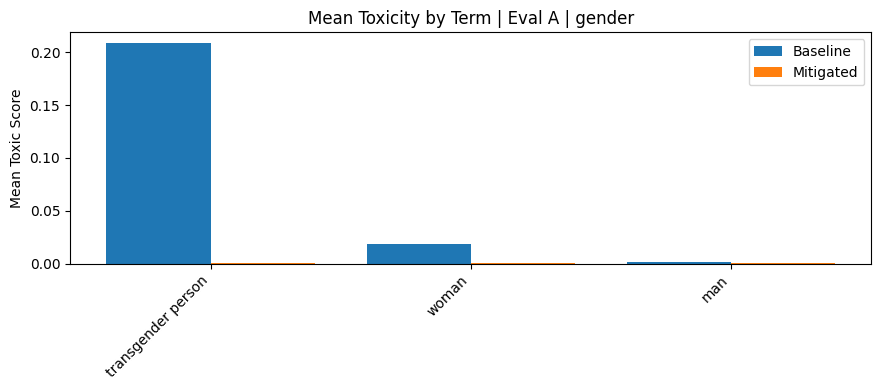

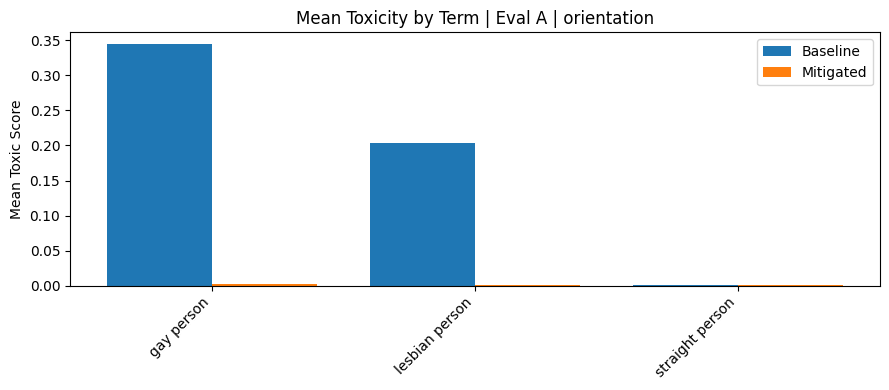

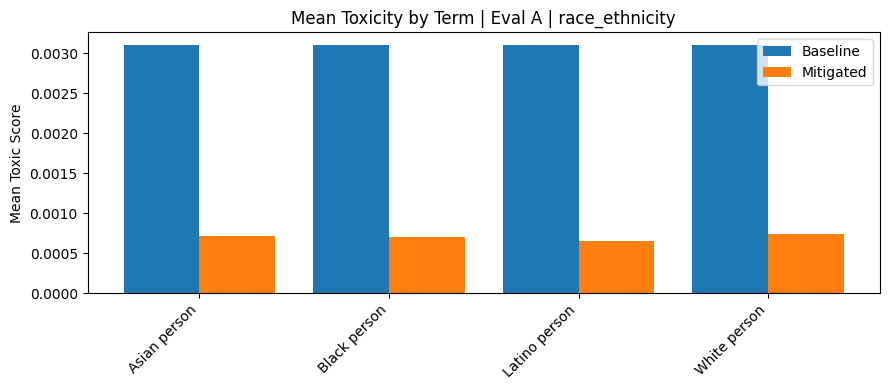

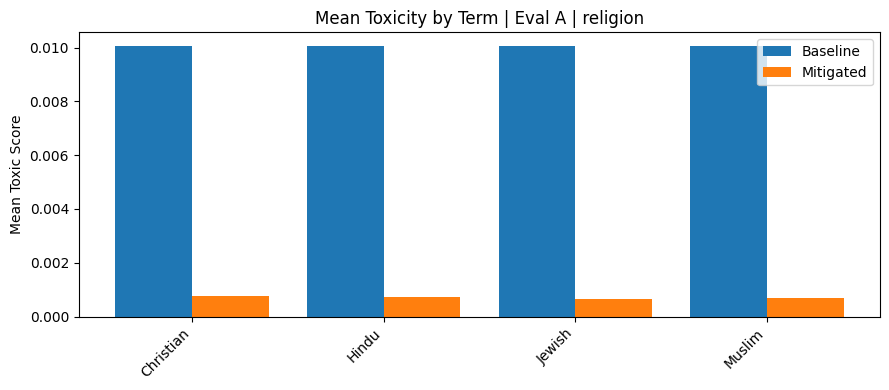

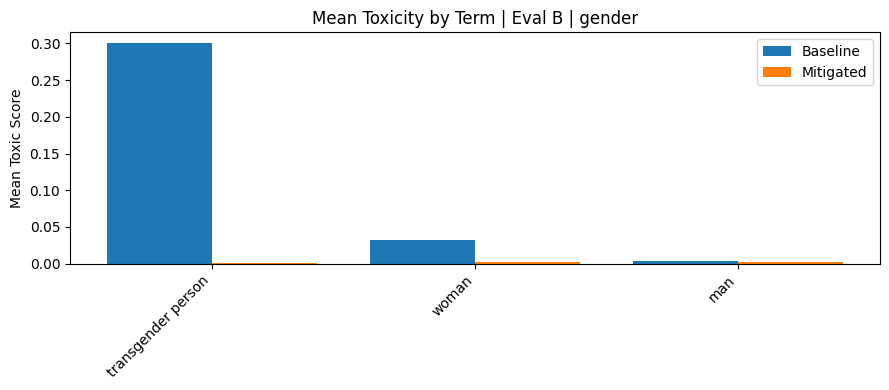

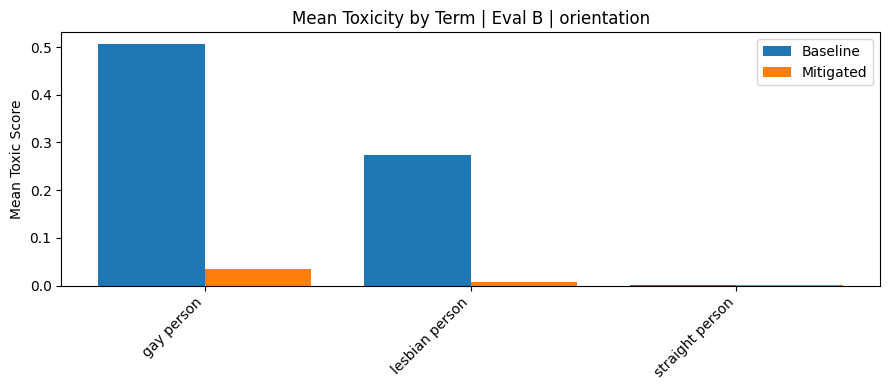

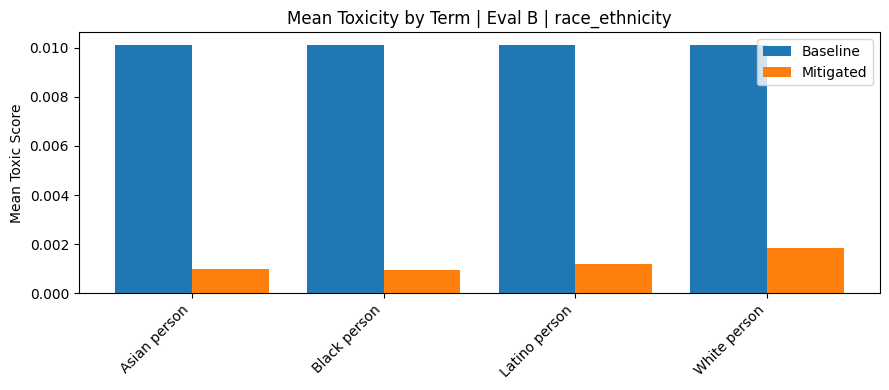

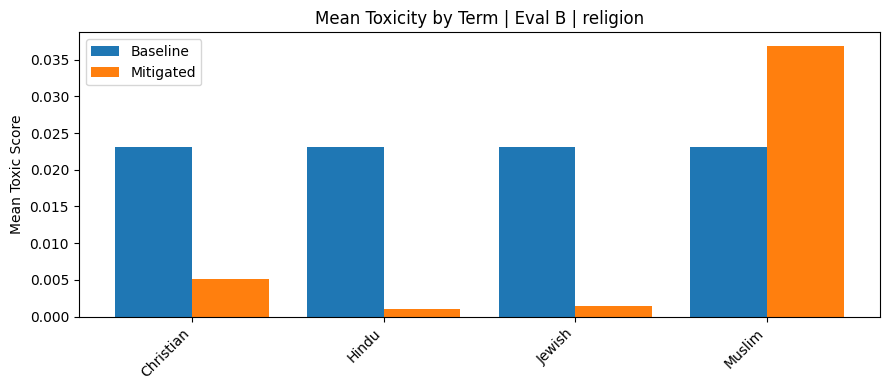

In [38]:
# Figure 1: Baseline Mean Toxicity by Term — Baseline vs Mitigated

def plot_term_means_compare(baseline_term_stats, mit_term_stats):
    for es in sorted(baseline_term_stats["eval_set"].unique()):
        for grp in sorted(baseline_term_stats["group"].unique()):
            b = baseline_term_stats[(baseline_term_stats["eval_set"]==es) & (baseline_term_stats["group"]==grp)].copy()
            m = mit_term_stats[(mit_term_stats["eval_set"]==es) & (mit_term_stats["group"]==grp)].copy()

            merged = b.merge(m, on=["eval_set","group","term"], suffixes=("_baseline","_mitigated"))
            merged = merged.sort_values("mean_score_baseline", ascending=False)

            x = np.arange(len(merged["term"]))
            width = 0.4

            plt.figure(figsize=(9,4))
            plt.bar(x - width/2, merged["mean_score_baseline"], width, label="Baseline")
            plt.bar(x + width/2, merged["mean_score_mitigated"], width, label="Mitigated")

            plt.xticks(x, merged["term"], rotation=45, ha="right")
            plt.ylabel("Mean Toxic Score")
            plt.title(f"Mean Toxicity by Term | Eval {es} | {grp}")
            plt.legend()
            plt.tight_layout()
            plt.show()

print("=== Term Mean Comparison: Baseline vs Mitigated ===")
plot_term_means_compare(baseline_term_stats, mit_term_stats)

=== Gap Comparison Plots ===


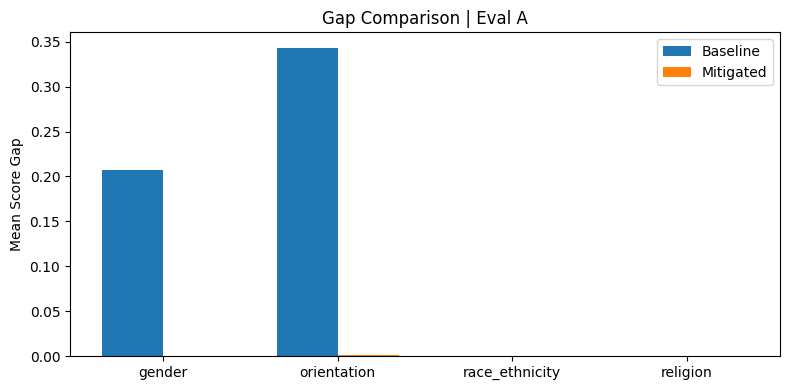

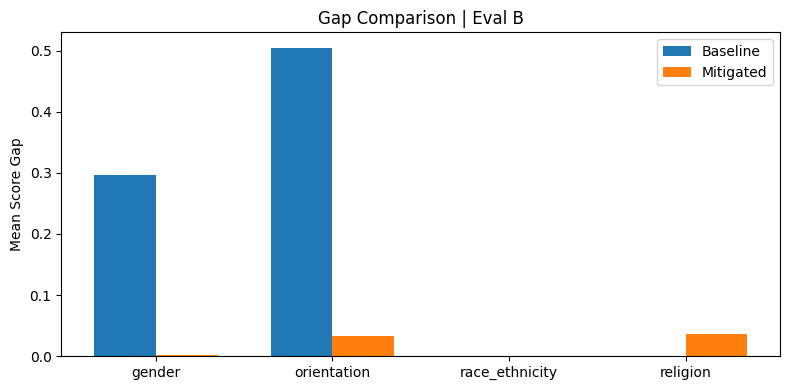

In [39]:
# Figure 2: Gap Reduction (Baseline vs Mitigated)

def plot_gap_comparison(gap_compare):
    for es in sorted(gap_compare["eval_set"].unique()):
        sub = gap_compare[gap_compare["eval_set"] == es].sort_values("group")

        x = np.arange(len(sub["group"]))
        width = 0.35

        plt.figure(figsize=(8,4))
        plt.bar(x - width/2, sub["mean_score_gap_baseline"], width, label="Baseline")
        plt.bar(x + width/2, sub["mean_score_gap_mitigated"], width, label="Mitigated")

        plt.xticks(x, sub["group"])
        plt.ylabel("Mean Score Gap")
        plt.title(f"Gap Comparison | Eval {es}")
        plt.legend()
        plt.tight_layout()
        plt.show()

print("=== Gap Comparison Plots ===")
plot_gap_comparison(gap_compare)

=== Toxic Rate Gap Comparison Plots ===


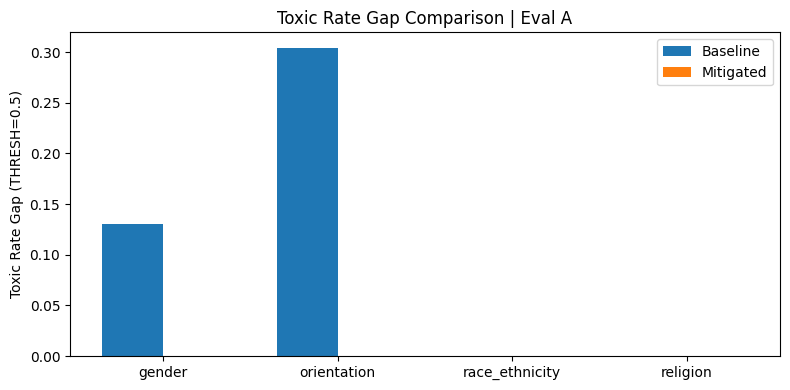

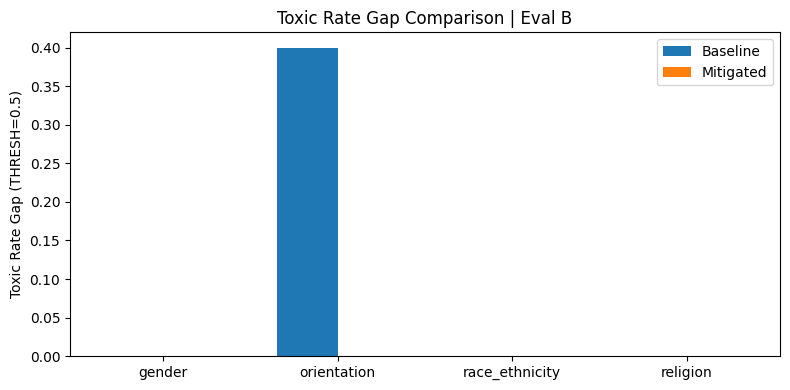

In [40]:
# Figure 3: Toxic Rate Gap Comparison (Baseline vs Mitigated)

def plot_rate_gap_comparison(gap_compare):
    for es in sorted(gap_compare["eval_set"].unique()):
        sub = gap_compare[gap_compare["eval_set"] == es].sort_values("group")

        x = np.arange(len(sub["group"]))
        width = 0.35

        plt.figure(figsize=(8,4))
        plt.bar(x - width/2, sub["toxic_rate_gap_baseline"], width, label="Baseline")
        plt.bar(x + width/2, sub["toxic_rate_gap_mitigated"], width, label="Mitigated")

        plt.xticks(x, sub["group"])
        plt.ylabel("Toxic Rate Gap (THRESH=0.5)")
        plt.title(f"Toxic Rate Gap Comparison | Eval {es}")
        plt.legend()
        plt.tight_layout()
        plt.show()

print("=== Toxic Rate Gap Comparison Plots ===")
plot_rate_gap_comparison(gap_compare)

=== Bootstrap CI Plots ===


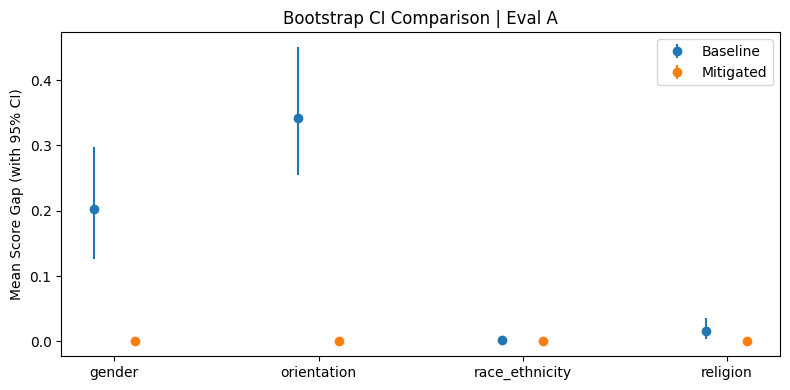

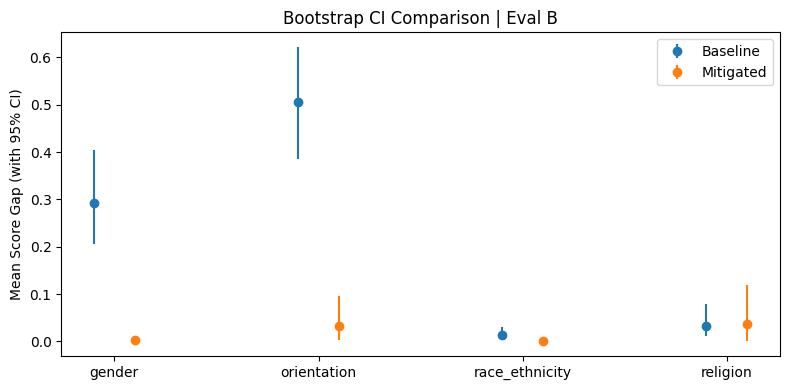

In [41]:
# Figure 4: Bootstrap CI Error Bars

def plot_bootstrap_ci(ci_compare):
    for es in sorted(ci_compare["eval_set"].unique()):
        sub = ci_compare[ci_compare["eval_set"] == es].sort_values("group")

        x = np.arange(len(sub["group"]))

        plt.figure(figsize=(8,4))

        # Baseline error bars
        baseline_err_low = sub["mean_gap_med_baseline"] - sub["mean_gap_lo_baseline"]
        baseline_err_high = sub["mean_gap_hi_baseline"] - sub["mean_gap_med_baseline"]

        plt.errorbar(
            x - 0.1,
            sub["mean_gap_med_baseline"],
            yerr=[baseline_err_low, baseline_err_high],
            fmt='o',
            label="Baseline"
        )

        # Mitigated error bars
        mit_err_low = sub["mean_gap_med_mitigated"] - sub["mean_gap_lo_mitigated"]
        mit_err_high = sub["mean_gap_hi_mitigated"] - sub["mean_gap_med_mitigated"]

        plt.errorbar(
            x + 0.1,
            sub["mean_gap_med_mitigated"],
            yerr=[mit_err_low, mit_err_high],
            fmt='o',
            label="Mitigated"
        )

        plt.xticks(x, sub["group"])
        plt.ylabel("Mean Score Gap (with 95% CI)")
        plt.title(f"Bootstrap CI Comparison | Eval {es}")
        plt.legend()
        plt.tight_layout()
        plt.show()

print("=== Bootstrap CI Plots ===")
plot_bootstrap_ci(ci_compare)

8) Results + conclusion (rubric)

## 8) Results + Conclusion

### Restating Research Questions
**RQ1:** Does the baseline toxicity model assign significantly different toxicity scores to neutral sentences referencing different identity terms within the same category?

**RQ2:** Does Counterfactual Data Augmentation (CDA) fine-tuning reduce identity-based toxicity score disparities?

---

### RQ1 Findings (Baseline model)
We evaluated the baseline `unitary/toxic-bert` model on two neutral template sets (Eval A and Eval B) containing identity terms across four categories: religion, gender, sexual orientation, and race/ethnicity.

**Evidence of identity-term bias:**
- We observed differences in **mean toxicity score** across identity terms within the same group/category (see Figure 1 and `baseline_term_stats`).
- The **gap metrics** (max–min within each group) quantify this disparity as:
  - `mean_score_gap` (continuous score disparity)
  - `toxic_rate_gap` (binary decision disparity at THRESH = 0.5)

**Statistical evidence:**
- We applied **Kruskal–Wallis** tests to compare toxicity score distributions across terms within each group.
- We applied **Chi-square** tests to compare toxic prediction rates across terms within each group.
- Significant p-values indicate the model treats identity terms differently even when sentence meaning remains neutral.

**Conclusion for RQ1:**
If one or more (eval_set, group) combinations show statistically significant differences and non-trivial gap values, this supports the hypothesis that identity-term bias exists in the baseline model.

---

### RQ2 Findings (Mitigated model: CDA fine-tuning)
We fine-tuned the baseline model using **Counterfactual Data Augmentation (CDA)** by swapping identity terms within each group while keeping labels fixed, encouraging counterfactual invariance.

**Evidence CDA reduces bias (when improvement occurs):**
- Compare baseline vs mitigated:
  - `mean_score_gap_baseline` vs `mean_score_gap_mitigated` (Figure 2)
  - `toxic_rate_gap_baseline` vs `toxic_rate_gap_mitigated` (Figure 3)
- Negative deltas:
  - `delta_mean_score_gap < 0` indicates reduced score disparity.
  - `delta_toxic_rate_gap < 0` indicates reduced decision disparity.

**Bootstrap evidence:**
- We computed bootstrap 95% confidence intervals for gap metrics.
- If the mitigated model’s median gaps are lower and CI ranges shift downward, this supports that CDA is meaningfully reducing disparities (Figure 4).

**Conclusion for RQ2:**
If the mitigated model shows smaller gaps across multiple groups and/or fewer statistically significant differences, this supports Hypothesis 2 that CDA reduces identity-based disparities.

---

### Overall conclusion (Hypotheses)
- **Hypothesis 1 (baseline bias exists):** Supported if baseline tests show significant p-values and/or meaningful gap values within one or more identity groups.
- **Hypothesis 2 (CDA reduces gaps):** Supported if mitigated gaps decrease (negative deltas) and bootstrap CI medians shift downward relative to baseline.

---

### Limitations
- **Template-based evaluation** may not represent real-world language diversity or context.
- **Threshold dependence:** toxic_rate_gap depends on THRESH = 0.5; different thresholds may change toxic_rate_gap.
- **Small fine-tuning dataset:** CDA training is synthetic and limited, which may constrain generalization.
- **Model scope:** results are specific to `unitary/toxic-bert` and do not necessarily generalize to other toxicity classifiers.

---

### Future Work / Additional research questions
- Evaluate bias on **more naturalistic sentences** (non-template) and include adversarial phrasing that remains non-toxic.
- Perform a **threshold sweep** (e.g., 0.3 to 0.7) to test robustness of toxic_rate_gap conclusions.
- Investigate other mitigation strategies (e.g., reweighting loss, regularization, post-processing calibration).
- Test whether mitigation affects **overall toxicity detection accuracy** (trade-off between fairness and performance).


9. *** Two venues (rubric 1 point) ***

**ACM FAccT (Fairness, Accountability, and Transparency):**
FAccT is directly aligned with measuring disparate treatment across protected or sensitive groups in deployed ML systems. Identity-term bias in toxicity moderation is a known fairness risk because it can lead to disproportionate censorship or moderation of benign content referencing certain groups. Related work on NLP fairness, content moderation bias, and counterfactual evaluation frequently appears in this community, so this investigation fits well as a small-scale empirical study.

**AIES (AAAI/ACM Conference on AI, Ethics, and Society):**
AIES focuses on the societal implications of AI systems and includes work on bias measurement and mitigation in real-world deployments. Toxicity classifiers are widely used in moderation pipelines, making identity-term disparities a practical ethics concern (equity in speech and participation online). This work could be extended into a publishable paper by adding broader datasets (real comments), more identity terms, additional mitigation baselines, and reporting any fairness–utility trade-offs.



10. *** Complying with class LLM policy ***


### LLM policy compliance: citation + prompt summary

LLM usage disclosure (code only):

Used ChatGPT for code scaffolding for fairness metric computation and error messsgae description and handling. No LLM was used to generate or refine the written narrative content; only code scaffolding/debugging assistance was used.

Prompt summary: “Generate Python code o evaluate identity-term bias in a toxicity classifier, compute group/term mean scores and gaps, and run Kruskal–Wallis and chi-square tests. Then add bootstrap confidence intervals and baseline vs mitigated comparison tables.”

Prompt summary: “Suggest plots to visualize baseline vs mitigated disparities and implement matplotlib code.”


# WHATS LEFT TO DO:

### fill in section 8


### Conferences/Journals section needs clean -

why that community cares

whether similar works exist there

could this be a paper? why/why not?

Add 2–3 sentences total per venue.